# Determining Climbing Route Styles of Mountain Project Sport Routes
#### Clara McIntyre and Andres Rivas

Mountain Project is essentially an online guidebook that contains information about rock climbing routes all over the world. It allows climbers to look at routes by location, difficulty, and/or star rating to determine what they are interested in climbing. ![Mountain Project Home Screen](Mountain_proj_home.png)

For each route on Mountain Project there is a bunch of associated helpful information, such as the rating of the route, it's location, the difficulty, and most importantly, a text description. The Kaggle Dataset we use https://www.kaggle.com/datasets/pdegner/mountain-project-rotues-and-forums?resource=download contains 116,700 of such routes from Mountain project, with their associated metadata. We are particularly interested in the text descriptions. They commonly talk about what it is like to climb the route, the type of gear needed to climb it, and also they style of climbing involved in the route. Climbing style is essentially what it is like to climb the route. Style is important because each climber tends to have a type of style they prefer, for example someone may really like routes with lots of small holds. Unfortunately, Mountain Project has no simple way to tell the style of routes without going through and reading a bunch of descriptions. Therefore, we want to see if topic models can be leveraged to determine the climbing styles involved in routes. We specifically want to focus on sport routes as opposed to trad or alpine routes because sport routes tend to have a diverse range of style. ![Mountain Project Route](Just_Do_It.png)

## Data Pre-Processing

To begin this process, we need to clean up our data and get it into a workable form for our topic model. To make this process easier we will be keeping our data in a Pandas dataframe. Our cleaning steps include removing unnecessary data columns, removing non sport routes, removing routes with no descriptions or overly long descriptions, and making sure we only include routes with English descriptions. With this cleaning process we go from having 116,700 routes in our dataset to 62,544 routes.

### Read in the Mountain Project csv into pandas dataframe

We start by reading in the Mountain Project data CSV from the Kaggle dataset into a dataframe. We can look at the column names to ensure our data was read in properly and gain an understanding of what type of data we have access to.

In [48]:
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

In [49]:
# Importing modules
import pandas as pd

file_path = "dataset/mp_routes.csv"

# Read data into papers
df = pd.read_csv(file_path)

# Print head
df.head()

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
0,0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,https://www.mountainproject.com/route/11014983...,2.9,Sport,5.10b/c,4,350.0,25.95044,-100.47755,This is a really great route~ with awesome exp...,12 draws + 60m Rope Take 22 draws if you wan...,22
1,1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,https://www.mountainproject.com/route/11091386...,2.0,Sport,5.10b/c,1,NaN,51.09642,-115.31767,from tabvar: Cool fins to roof~ thin holds...,4 bolts to anchor,1
2,2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,https://www.mountainproject.com/route/11240652...,2.7,Trad,5.10b/c,1,NaN,50.57212,-120.13874,A safe mixed route with a bit of run out up to...,"mixed~ gear to 4""",3
3,3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,https://www.mountainproject.com/route/11608640...,2.0,Sport,5.10b/c,1,80.0,26.01097,-111.34166,Start on a slab under a left leaning arched ro...,bolts,1
4,4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,https://www.mountainproject.com/route/11445772...,3.0,Sport,5.10b/c,1,60.0,49.71393,-123.09943,Fun technical climbing. Tricky right off the bat.,bolts,3


In [50]:
# Print the column names
print(df.columns)

# Print number of rows
print("Number of routes:", len(df))

Index(['Unnamed: 0', 'Route', 'Location', 'URL', 'Avg Stars', 'Route Type',
       'Rating', 'Pitches', 'Length', 'Area Latitude', 'Area Longitude',
       ' desc', ' protection', ' num_votes'],
      dtype='object')
Number of routes: 116700


### Dropping Unwanted Data Columns

There are a number of columns in the data that are not interesting to us and probably won't be interesting in future exploration, so we can go ahead and remove those columns. These columns include things like 'Area Latitude' and 'protection' that probably do not play any significant role in climbing styles.

In [51]:
# Remove the columns
df = df.drop(columns=['Unnamed: 0', 'URL', 'Pitches', 'Length', 'Area Latitude', 'Area Longitude', ' protection', ' num_votes'], axis=1)

# Print out the first rows of papers
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,This is a really great route~ with awesome exp...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar: Cool fins to roof~ thin holds...
2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,2.7,Trad,5.10b/c,A safe mixed route with a bit of run out up to...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,Start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,Fun technical climbing. Tricky right off the bat.


In [52]:
print(df.columns)

Index(['Route', 'Location', 'Avg Stars', 'Route Type', 'Rating', ' desc'], dtype='object')


### Remove all non sport or top rope routes
Let's also remove all non sport or top rope (TR) routes. We decide to focus on sport climbs and top ropes because trad routes or alpine most commonly have a crack style or non rock specific style which then makes it difficult for the topic model to find clear categories with other style types. Thus, by removing these types of routes we can get a more diverse set of styles in our topic modeling. Doing so cuts down the number of routes in our dataset from 116,700 to 65,298.

In [53]:
# Print the number of rows before removal
print("Number of rows before removal:", len(df))

# Get unique values from the route type
unique_values = df['Route Type'].unique()
print(unique_values)

# routes that are not TR or Sport
df = df[(df['Route Type'] == 'Sport') | (df['Route Type'] == 'TR') | (df['Route Type'] == 'Sport, TR') | (df['Route Type'] == 'Sport, TR, Boulder')]

# Print the number of rows before removal
print("Number of rows after removal:", len(df))

Number of rows before removal: 116700
['Sport' 'Trad' 'Trad, Alpine' 'Sport, TR' 'Sport, Alpine' 'Trad, Sport'
 'Trad, TR' 'Sport, Aid' 'Trad, Aid' 'Trad, Aid, Alpine'
 'Trad, TR, Alpine' 'Trad, Snow, Alpine' 'Trad, Sport, TR' 'Trad, Boulder'
 'Sport, TR, Alpine' 'Trad, TR, Boulder' 'Trad, Ice' 'Trad, Snow'
 'Trad, Ice, Alpine' 'Trad, Ice, Snow, Alpine' 'Trad, Mixed, Alpine'
 'Trad, Mixed, Ice, Alpine' 'Trad, Mixed, Ice, Snow, Alpine'
 'Trad, Ice, Snow' 'Trad, Mixed, Snow, Alpine' 'Sport, Boulder'
 'Trad, Sport, Alpine' 'Trad, TR, Aid' 'Trad, Mixed, Ice' 'Trad, Mixed'
 'Trad, Sport, Aid' 'Sport, Aid, Alpine' 'Trad, Aid, Snow, Alpine'
 'Sport, Mixed, Ice' 'Trad, TR, Mixed, Ice' 'Sport, Mixed'
 'Trad, Aid, Boulder' 'Sport, Snow' 'Sport, TR, Aid'
 'Sport, Aid, Boulder, Mixed, Ice, Snow' 'Trad, Aid, Ice, Alpine'
 'Sport, TR, Boulder' 'Sport, TR, Aid, Boulder' 'Trad, Sport, TR, Alpine'
 'Trad, Mixed, Ice, Snow' 'Trad, Sport, Aid, Boulder, Ice, Snow'
 'Trad, Aid, Boulder, Alpine' 'Trad, Boul

In [46]:
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,This is a really great route~ with awesome exp...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar: Cool fins to roof~ thin holds...
2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,2.7,Trad,5.10b/c,A safe mixed route with a bit of run out up to...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,Start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,Fun technical climbing. Tricky right off the bat.


### Remove any routes with overly long or short descriptions

Let's now make sure we don't include any routes in our cleaned data with overly long text descriptions or no description at all. To do this, we start by looking at some statistics about the lengths of our route descriptions and plotting them using a histogram. From this histogram we can see that most descriptions are less than 2000 words, so we will remove any outliers that are longer than this since excessively long descriptions tend to ramble about non-style related topics.

Number of rows before removal: 65298
Statistics of Route Description Lengths:
Number of Descriptions: 65103
Total Words in Descriptions: 279616.08
Mean Length: 257.70 words
Standard Deviation: 283.83 words
Minimum Length: 1.00 words
Maximum Length: 9525.00 words


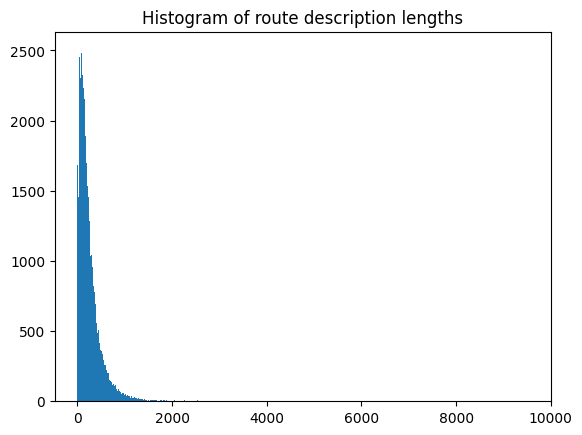

In [54]:
import matplotlib.pyplot as plt

# Print the number of rows before removal
print("Number of rows before removal:", len(df))

# remove rows with no description
df = df[(df[' desc'].str.split().str.len() > 0)]

# Iterate through each description in the 'desc' column and create a list of lengths
description_lengths = [len(desc) for desc in df[' desc']]

# Convert the list to a numpy array for easy calculations
len_desc = np.array(description_lengths)

num_clips = len(len_desc)
total_length = sum(len_desc)
mean_length = np.mean(len_desc)
std_deviation = np.std(len_desc)
min_length = np.min(len_desc)
max_length = np.max(len_desc)

print("Statistics of Route Description Lengths:")
print("============================")
print(f"Number of Descriptions: {num_clips}")
print(f"Total Words in Descriptions: {(total_length / 60):.2f}")
print(f"Mean Length: {mean_length:.2f} words")
print(f"Standard Deviation: {std_deviation:.2f} words")
print(f"Minimum Length: {min_length:.2f} words")
print(f"Maximum Length: {max_length:.2f} words")

_ = plt.hist(len_desc, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of route description lengths")
plt.show()

In [55]:
# Remove rows with descriptions containing more than 2000 words
df = df[(df[' desc'].str.split().str.len() <= 2000)]

# Print the number of rows after removal
print("Number of rows after removal:", len(df))

Number of rows after removal: 65103


In [56]:
df[' desc'].head()

0    This is a really great route~ with awesome exp...
1    from tabvar:     Cool fins to roof~ thin holds...
3    Start on a slab under a left leaning arched ro...
4    Fun technical climbing. Tricky right off the bat.
5    Two potential starts. 1) Travers across canyon...
Name:  desc, dtype: object

### Remove any routes with non-English descriptions
Now that we have gotten rid of any overly long or short descriptions, let's make sure they are all in English using the langdetect library. The routes are from all over the world, so we want to only look at those with English descriptions otherwise it will be really hard for us to label the topics later.

In [57]:
from langdetect import detect

# Function to check if a text is in English using langdetect
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
# Remove rows where the description is not in English
df = df[df[' desc'].apply(is_english)]

# Print the number of rows after removal of non-English
print("Number of rows after removal:", len(df))

Number of rows after removal: 62544


### Remove punctuation and lowercase all descriptions

Now let'a get rid of punctuation so that it does not mess up our topics and lowercase all of our descriptions so that there are fewer unique tokens/words.

In [58]:
import string

# Remove punctuation and convert to lowercase
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text.lower()

# Apply text cleaning to the description column
df[' desc'] = df[' desc'].apply(clean_text)

df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat
5,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...


###  Save cleaned data to csv

Now that we have our cleaned up data let's save it to a CSV so that the cleaning process does not need to be redone every time one wants to rerun the topic model code. After cleaning there are 112,699 climbing routes.

In [59]:
df.to_csv("mp_routes_clean.csv", encoding='utf-8', index=False)

## Topic Modeling!

Now that we have pre-processed the data let's play with it! We will do this using a Tomotopy topic model. The topic model will find different topics within our route descriptions that we can then manually map to different climbing styles. These mappings can then be used to label our different routes with the different styles they fall within.

### Read in cleaned data

In [60]:
# Importing modules
import pandas as pd

file_path = "mp_routes_clean.csv"

# Read data into papers
df = pd.read_csv(file_path)

# Print head
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat
4,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...


### Train Topic Model

We train a tomotopy topic model with 30 different topics for 1000 iterations. In addition to the stopwords from nltk.corpus, we will add more of our own that are climbing related but not climbing style related. Doing this will help make each of our topics more climbing style specific and reduce the number of non-style related topics that are generated. After training our model we look at the top 25 words per topic to start to get a sense of what each of our topics are. Then, to further understand our topics we look at the top 5 documents for each topic. By doing both of these things we can narrow down which of our topics are climbing style related and then determine which style they correspond to. Not all of our topics will be style related or correspond to one clear style. However, with those that are, we can create a mapping from the topic to a style label and use that mapping to label our routes with styles.

In [61]:
import tomotopy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cfmci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Add certain climbing terms that are not route style related to our stoplist

In [62]:
more_stop_words = {"anchor", "bolt", "climb", "belay", "left", "right", "bolts", "climbed", "first", "ascent", "north", "east", "south", "west", 
                   "rap", "route", "pitch", "pro", "cam", "cams", "finish", "crux", "start", "classic", "quality", "excellent", "fun", "climbing", "bolted", 
                   "cruxes", "good", "great", "guide", "guidebook", "description", "book", "routes", "rating", "located", "side", "trail", "cliff", "approach", 
                   "rope", "drag", "top", "rated", "pitches", "ropes", "anchors", "rope", "lower", "bolted", "tree", "trees", "lead", "snow", "follow", "trad",
                   "gear"}

In [63]:
# 30-topic model populated with documents from our reviews (with stopwords removed)
stoplist = set(stopwords.words('english'))
stoplist.update(more_stop_words)

n_topics = 30
n_docs = len(df)

mdl = tomotopy.LDAModel(k=n_topics)
for desc in df[' desc']:
  words = desc.split()
  mdl.add_doc([w for w in words if w not in stoplist and w.isalpha()])

In [64]:
# Most converging will happen fast, but we'll run for 1000 iterations just in case
# (this will take a minute)
iters_per_check = 50
for i in range(0, 1000, iters_per_check):
    mdl.train(iters_per_check)
    print('Iteration: {}\tLog-likelihood: {}'.format(i+iters_per_check, mdl.ll_per_word))

Iteration: 50	Log-likelihood: -8.710402456233307
Iteration: 100	Log-likelihood: -8.522859130893297
Iteration: 150	Log-likelihood: -8.4451444058873
Iteration: 200	Log-likelihood: -8.401185571379184
Iteration: 250	Log-likelihood: -8.373062910383434
Iteration: 300	Log-likelihood: -8.351515732775159
Iteration: 350	Log-likelihood: -8.343315254420258
Iteration: 400	Log-likelihood: -8.329662520337212
Iteration: 450	Log-likelihood: -8.32149439179715
Iteration: 500	Log-likelihood: -8.318536997149122
Iteration: 550	Log-likelihood: -8.313751229276205
Iteration: 600	Log-likelihood: -8.311176370207566
Iteration: 650	Log-likelihood: -8.305661878595881
Iteration: 700	Log-likelihood: -8.307233996611597
Iteration: 750	Log-likelihood: -8.305061267388966
Iteration: 800	Log-likelihood: -8.306919006392839
Iteration: 850	Log-likelihood: -8.305871403914544
Iteration: 900	Log-likelihood: -8.29921849296512
Iteration: 950	Log-likelihood: -8.298412861810633
Iteration: 1000	Log-likelihood: -8.29484238278637


### Top 25 words per topic

In [65]:
# Print top 25 words of each topic
print("Top 25 words by topic")
for k in range(n_topics):
    print('#{}: {}'.format(k, ' '.join([w for (w, prop) in mdl.get_topic_words(k, top_n=25)])))

Top 25 words by topic
#0: moves leads easier easy tricky thin section hard slab move steep technical face bulge sustained short bouldery rest holds second ground interesting powerful gets difficult
#1: line project new years name originally fa one named original done put time added old since sport many recently climbers got used open bolting later
#2: clip second clipping stick fall third ground long last make ledge would high want draw two may feet could use getting runout belayer draws dont
#3: slab pockets rock small holds edges face crimps thin feet angle low moves vertical bulge sharp starts nice features steep section technical bit way near
#4: bit harder grade holds little easier much like one line may hard difficult quite pretty looks moves probably still get though short better rock way
#5: wall face line past climbs main two rock area feet large base three far short end boulder center starts near one crag middle gully steep
#6: rock clean dirty traffic little bit still lichen

### Top 5 docs per topic

In [82]:
# Printing the top 5 documents per topic
for topic_id in range(n_topics):
    print(f"Topic {topic_id + 1}:")
    topic_words = mdl.get_topic_words(topic_id, top_n=25)
    print("Top words:", ', '.join(word for word, prob in topic_words))
    print("Top documents:")
    
    # Enumerate through all documents and calculate the probability of each document belonging to the current topic
    doc_probabilities = [(doc_id, doc.get_topic_dist()[topic_id]) for doc_id, doc in enumerate(mdl.docs)]
    # Sort the documents by their probability for the current topic
    doc_probabilities.sort(key=lambda x: x[1], reverse=True)
    
    # Print top 5 documents
    for doc_id, doc_prob in doc_probabilities[:5]:
        print(f"Document {doc_id}: Probability {doc_prob:.4f} - {df[' desc'][doc_id]}")
    print()

Topic 1:
Top words: moves, leads, easier, easy, tricky, thin, section, hard, slab, move, steep, technical, face, bulge, sustained, short, bouldery, rest, holds, second, ground, interesting, powerful, gets, difficult
Top documents:
Document 37608: Probability 0.8298 - excellent route and great introduction to the crag   quality holds tonthe top with great moves
Document 30453: Probability 0.7835 - neverland 59  95180 f 917b   climb the face left of the large crackchimney to the mid point anchors on the big ledge or all the way to the top  be careful of rope drag on the upper section also be carful apparently there is a snake den right at the base as well as a bunch of poison ivy can also be done as 2 pitches   p1  58  95 f 9b  begin at the edge of the chimney and traverse left over broken rock then climb directly up to the large ledge with the 2 chain anchors   p2  59  85 f 7b  continue up the face above to the high crux and 2 bolt anchors on top best to rappel and not lower from top

In [67]:
# Survey stats
# See https://bab2min.github.io/tomotopy/v0.4.1/en/#tomotopy.LDAModel.infer
mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.7)
| 62383 docs, 1286080 words
| Total Vocabs: 42724, Used Vocabs: 42724
| Entropy of words: 7.40789
| Entropy of term-weighted words: 7.40789
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.29484
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 30 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 650029957 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.405

## Label Topics Related to Climbing Route Styles
Looking at the topics and the top 5 documents associated with each we can create a `label_to_topics` mapping. Then using this mapping we can label each of the routes in our dataset. We allow each route to get multiple labels since climbs may encompass more than one style. We label a route with a style if its description has more than `threshold` proportion of the corresponding topic. We determine the `threshold` value by manually going through a random sample of 20 routes and calculating the number of distinct styles that appear on average in each route. If no style can be reasonably associated with a route, it is labeled as unknown. We also include code to label each route with only its top style, if desired.

In [68]:
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

In [84]:
label_to_topics = {"crimpy":[4], "face climb":[6], "crack":[8], "overhung":[9], "corner/dihedral/arete":[17], "technical/sustained":[19], "powerful/bouldery":[20]}

In [139]:
# Let's get the topic proportions for each document
doc_topic_props = np.zeros(shape=(n_docs, n_topics))
for i, doc in enumerate(mdl.docs):
    doc_topic_props[i, :] = doc.get_topic_dist()

### Determine threshold value
Randomly sample 20 routes from the data and make a list of manual counts of the number of styles in each route description. Then compute the mean style count. Later, after labeling routes with different styles based on their topic proportions in the topic model, the average number of styles assigned per route, excluding the routes labeled as 'unknown' should be similar to this value. We manually tweak `threshold` in order to improve the similarity between the actual average number of styles per route, determined by our random sampling, and the assigned average number of styles per route, determined by the topics to style mapping.

In [102]:
import statistics

pd.set_option('max_colwidth', None)
# df = df.drop(columns=['labels'], axis=1)
df.sample(n=20)

style_counts = [3, 2, 1, 3, 0, 2, 1, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 1, 2]

avg_count = statistics.mean(style_counts)
print(avg_count)

1.6842105263157894


In [133]:
threshold = 1/(n_topics)
print(f"The threshold value is: {threshold}")

The threshold value is: 0.03333333333333333


### Assign multiple labels to each route
We use the `label_to_topics` mapping to assign all routes with their "best" matching styles. If a topic has greater than `threshold` proportion for a document/route description, then its corresponding style is added to that route's list of styles. If there are no styles that can be assigned to a route, then it gets an `[unknown]` style label.

In [134]:
# Let's initialize a list to store labels for each document
doc_labels = []

# Iterate through all the documents
for topic_dist in doc_topic_props:
    # Check if any topic appears with more than threshold
    relevant_topics = [topic_idx for topic_idx, proportion in enumerate(topic_dist) if proportion > threshold]
    
    # Initialize an empty list to store labels for this document
    labels_for_doc = []
    
    # Map relevant topics to their labels
    for topic_idx in relevant_topics:
        # Find labels for this topic
        labels_for_topic = [label for label, topics in label_to_topics.items() if topic_idx in topics]
        if labels_for_topic:
            # If labels exist for this topic add them to the list
            labels_for_doc.extend(labels_for_topic)

    # remove duplicate labels
    labels_for_doc = list(set(labels_for_doc))

    # Add "unknown" label only if labels_for_doc is empty
    if not labels_for_doc:
        labels_for_doc.append('unknown')
    
    # Add labels for this document to the list
    doc_labels.append(labels_for_doc)

# Now, add the labels as a new column to your DataFrame
df['style labels'] = doc_labels

In [135]:
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc,style labels
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > Northern Mexico > Mexico > North America > International,2.9,Sport,5.10b/c,this is a really great route with awesome exposure and a really cool summit it climbs obvious dihedrals and good face climbing up to the ridge p1 510a 11 bolts p2 510a 9 bolts p3 510c 9 bolts crux some cool handjams and good exposure p4 59 8 bolts jugs to the summit you can link pitches and do the route route in two pitches,[crack]
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUCTION IN PROGRESS > Bow Valley > Alberta > Canada > North America > International,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds over roof,[unknown]
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja California Sur > Mexico > North America > International,2.0,Sport,5.10b/c,start on a slab under a left leaning arched roof follow bolts up and left to the arete at the left hand side of the arching roof turn the roof and follow the bolts on the arete to a two bolt anchor at ledge,[unknown]
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > British Columbia > Canada > North America > International,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat,[crimpy]
4,Big Splash,The Dark Pool > Powell River > British Columbia > Canada > North America > International,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon and start at the roofdown climb to ledge 2 swim over bring your shoes and chalk and a towel and start on ledge below roof true start starting on this ledge grade unconfirmed cleaned and climbed 3 years ago top may be dirty fairly easy climb but interesting crux to turn the roof climb passed the crux roof then continue slightly right and straight up,[crimpy]


### Helper code for improving `threshold`
This code helps us determine for the routes with at least one assigned style, on average, how many styles are being assigned to each. This helps us know whether we should raise or lower our `threshold` value to better match the average number of styles per route determined by our random sampling test.

In [136]:
# Convert 'labels' column to a list of lists
labels_list = df['style labels'].tolist()

# Filter rows where 'labels' is not equal to ['unknown']
filtered_labels = [labels for labels in labels_list if labels != ['unknown']]

# Calculate the length of each list in the filtered labels
list_lengths = [len(labels) for labels in filtered_labels]

# Calculate the average length of the lists
average_length = np.mean(list_lengths)

print("Average length of lists (excluding 'unknown'): ", average_length)

Average length of lists (excluding 'unknown'):  1.6214751167752726


### Assign only one label to each route
Here is some alternative code if one wanted to only assign the top style label to each route.

In [127]:
# # Let's initialize a list to store labels for each document
# doc_labels = []

# # Iterate through all the documents
# for topic_dist in doc_topic_props:
#     relevant_topic = np.where(topic_dist == (max(topic_dist)))[0][0]
    
#     # Initialize an empty list to store labels for this document
#     labels_for_doc = []
#     labels_for_doc = [label for label, topics in label_to_topics.items() if relevant_topic in topics]

#     # Add "unknown" label only if labels_for_doc is empty
#     if not labels_for_doc:
#         labels_for_doc.append('unknown')
    
#     # Add labels for this document to the list
#     doc_labels.append(labels_for_doc)

# # Now, add the labels as a new column to your DataFrame
# df['labels'] = doc_labels

#### Random sampling of routes to see how good the labels are

In [138]:
pd.set_option('max_colwidth', None)
df.sample(n=30)

,Route,Location,Avg Stars,Route Type,Rating,desc,style labels
31666,Blender,Apollo Wall > Cathedral Domain Climbing Area (CDCA) > Red River Gorge > Kentucky,2.0,Sport,5.11b,has a slight angle on it this route will work you,"[technical/sustained, crimpy]"
53363,The Complete Bastard,Iron Curtain > Mount Iron > Wanaka > Otago > South Island > New Zealand > Oceania > International,3.0,Sport,5.12d,bring a 60m rope for this one start with climbing tbfgr finish is 30 feet higher,[crimpy]
48075,Stool Sample,The Einstein > Leslie Gulch > Northeast Oregon > Oregon,3.0,Sport,5.12b,overhanging pocketed pump fest maybe there are 4 natural holds on this route same start as iron lung stick clip recommended but head straight up after surmounting the roof very consistent climbing read endurance to a good rest on a flake then fight a mini boulder problem directly under the chains get on it,[technical/sustained]
19308,Beer Ledge,"C: Legacy Wall > 1: South, Climber's Left of Stairs > EM: Robinson Bluff > Missouri",3.2,Sport,5.10b,similar start to tennessee whisky but head up and left from the first bolt on the left side of the large stack of boulders crux is mid way up the route and greatly depends on if you are left or right of the bolt path finish on slightly easier climbing,"[powerful/bouldery, crack]"
38476,Bedroom Rodeo,Little Ass Kicker > Lower Wall > Cooks Wall > 3. Piedmont Region > North Carolina,2.3,Sport,5.10b/c,start in the right corner of the wall on a good right side pull and iron cross out left onto smaller holds pull a couple powerful moves getting established and fun steep climbing leads to the top,[unknown]
21112,Far From The Sea,Adam's Rib > Chestnut Mountain Crag > Southwest Region > Montana,2.7,Sport,5.10c,start up the shallow corner on slightly chossy rock clip a few bolts including one camod by a plant when the bolts seem to run out climb up and right around the shallow arete and onto the slap face a thin reachy crux then clip the chains fun route with a well defined well protected crux and mostly mellow climbing the rest of the way,"[powerful/bouldery, crack]"
21683,project,Lower Old Red Rock (Xia Lao Hong Yan) > Old Red Rock (Lao Hong Yan) > Fumin Canyon > Kunming Area > Yunnan Province > China > Asia > International,1.0,Sport,5.11+,route 5 on beta photo 11 bolts 30 m long abandoned go for the first ascent,[crimpy]
55723,The Violator,6 - Swallow Wall > The Dry Canyon > Southern Arizona > Arizona,2.6,Sport,5.10c/d,very tricky route much easier once you know where the holds are starts by a big ledge hold and then zigzags around the bolt line the crux comes relatively low in the route when you need to decide what to do when holds disappear an interesting thought provoking balance move to the anchors,[crimpy]
31977,Holier than Thou,B-Hole Wall > Hole in the Wall > Bald Rock Fork Recreational Preserve (BRRP) > Red River Gorge > Kentucky,3.4,Sport,5.11d,continuous pocket climbing leads to a good rest before taking on the overhung arete to the anchors,"[crimpy, crack]"
48065,Optigrab,(8) Anglin's Buttress > (v) Monument Area > Smith Rock > Central Oregon > Oregon,3.5,Sport,5.12b,optigrab starts out on choss like most routes on this wall but after the 56 climbing first 3 bolts the rock become remarkably solid cleaning this route was effortless almost nothing came off while the rock quality is 44 stars the route itself doesnt stand out with all the classics at smith rocks i would compare it in difficulty and quality to that 10d a sandbagged 12a at smith once the hard climbing begins it doesnt really let up until you get the last bolt clipped continuous delicate face moves on crimps and side pulls dominate this climb while this climb in entirely safe it forces you to climb hard above protection making it feel like most routes at smith rocks second thrid and fourth pitch coming soon like arete climbing if so your in luck these coming pitches are fully bolted aretes and redtagged all pitches should be cleaned sent and ready for actio

In [130]:
df.to_csv("mp_routes_labeled.csv", encoding='utf-8', index=False)

## Results
Looking at our random sampling of different routes and their assigned labels we can notice a few interesting things. Firstly, there are definitely some routes that are labeled with styles that do not seem to apply to the route. Specifically, there are some routes that seem like they would be better labeled with a different set of styles. One example of this is OB Juan labeled as `[crimpy]` with the description: "a short arete with an unusual crux hasnt been sent yet because i havent been back since drilling it morning shade" even though `[corner/dihedral/arete]` would have been a better classification, since crimpy routes involve very small holds which are not mentioned on the description. In these cases, there are probably other words within the description that are not style related but fall within the realm of the incorrectly assigned style topic.

There are also a number of routes that have been assigned multiple labels where only some of them are accurate. An example of this is General Admission labeled as `[technical/sustained, crimpy, crack]` with the description: "yard up the middle of the face past blocky ledges and crimpers be sure to save some gas for the final desperate move to anchors below a small roof". The `technical/sustained` and `crimpy` part of the description seem fitting since small holds are mentioned and "yarding" implies a hard moves. However, no sort of `crack` climbing is mentioned. It seems like a number of different style categories get accidentally lumped into the crack category such as climbs with roofs, like in this case, or climbs with aretes.

One curious thing is that a lot of climbs that are assigned styles are assigned the crimpy style, even if they do not seem crimpy based on the description. The top words for the crimpy topic are: slab, pockets, rock, small, holds, edges, face, crimps, thin, feet, angle, low, moves, vertical, bulge, sharp, starts, nice, features, steep, section, technical, bit, way, near. These mostly seem crimp related as they discuss types of small holds, but the topic also seems to encompass some general climbing ideas like "rock, holds, feet, moves". To improve this category the stopwords list should be refined.

While using topic modeling to group climbing routes into different categories is somewhat successful, it is far from perfect. In the random sampling above, using hand labeling 16 out of the 44 assigned style labels appear correct. This would improve to 21 out of 44 labels if the crack style category was widened to include aretes and roofs. These results aren't anywhere close to perfect, but they are better than the 6.3 out of 44 correct labels we'd expect if we left things to random chance. 

To improve the results the stopwords list could be refined to remove most non-style terms. Or maybe a better approach would be to abandon the topic modeling strategy and instead use a different technique for labeling style. One better technique could be creating a glossary of different climbing terms that could fall under a specific style and then going through each route description and labeling the route with styles based on the glossary.